In [5]:
import pandas as pd # to manage data frames and reading csv files
import numpy as np
#for the sigmoid function we need expit() from scipy
import scipy.special
#library for plotting arrays
import matplotlib.pyplot as plt

%matplotlib inline
# A particularly interesting backend, provided by IPython, is the inline backend. 
# This is available only for the Jupyter Notebook and the Jupyter QtConsole. 
# It can be invoked as follows: %matplotlib inline
# With this backend, the output of plotting commands is displayed inline 
# within frontends like the Jupyter notebook, directly below the code cell that produced it. 
# The resulting plots are inside this notebook, not an external window.
import seaborn as sns
sns.set_style("darkgrid")

# datasets to read
# you can change these when trying out other datasets
train_file = "mnist_train.csv"
test_file = "mnist_test.csv"


#read the file into a pandas frame
df = pd.read_csv(train_file, header=None) 

np.random.seed(42)

df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

y_train_all =  pd.get_dummies(df_orig_train[0]).values
X_train_all = df_orig_train.drop(0, axis = 1).values
#print(y_train_all.shape)
#print(X_train_all.shape)

y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
#print(y_test_all.shape)
#print(X_test_all.shape)


# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 1500  # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)

X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
#print(y_train.shape)
#print(X_train.shape)

#preprocessing steps
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
#print(y_train.shape)

test_sample_size = 100 
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
#print(y_test.shape)
#print(X_test.shape)

X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)


def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy


class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
    def backward(self, inputs):
        self.output = np.greater(inputs, 0).astype(int) # inputs > 0 then convert bools to int
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))
    

class Layer_Dense:
    def __init__(self, n_inputs, n_neurons, learningrate=0.01, activation='sigmoid'):
        
        self.weights = np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        #print(self.weights.shape)
        self.biases = np.zeros((1, n_neurons))
       
        self.lr = learningrate
        self.activate=activation  
        
    def forward(self, inputs):
        self.in_values = inputs
        self.layer_input = np.dot(inputs , self.weights) + self.biases
        self.activation()
    
    def activation(self):
        if self.activate == 'sigmoid':
            a = Activation_Sigmoid()
            self.layer_output = a.forward(self.layer_input)
            
           
    def del_activation(self):
        if self.activate == 'sigmoid':
            del_a = Activation_Sigmoid()
            self.del_layer_output =  del_a.backward(del_a.forward(self.layer_input))
      
    def backward(self, delta_in, weights_in, targets=None, output_layer=False):
        self.del_activation()
        if output_layer:
            self.layer_error = self.layer_output - targets
            self.layer_delta = self.layer_error * self.del_layer_output
        else:          
            self.layer_error = np.dot(delta_in, weights_in.T)
            self.layer_delta = self.layer_error * self.del_layer_output
        
    def weight_update(self, prev_layer_output):
        # print("prev_layer_output.T.shape: "+str(prev_layer_output.T.shape))
        # print("self.layer_delta.shape: "+str(self.layer_delta.shape))
        N = self.layer_delta.shape[0]
        weights_update = np.dot(prev_layer_output.T, self.layer_delta) / N
        # print(weights_update.shape)
        self.weights -= self.lr * weights_update
        biases_update = np.mean(self.layer_delta, axis=0, keepdims=True)
        # print("biases_update.shape: "+ str(biases_update.shape))
        # print("self.biases.shape: "+ str(self.biases.shape))
        self.biases -= self.lr * biases_update


class ANN():
    def __init__(self, ouput_layer, hidden_layer, batch_size = 10):
        self.output = ouput_layer
        self.layer1 = hidden_layer
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, lr):
        self.layer1.lr = lr
        self.output.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x)
                #print('layer1 output \n' ,layer1.layer_output.shape)
                self.output.forward(self.layer1.layer_output)
                # print('layer output  \n', output.layer_output.shape)

                # backprop through the layers 
                self.output.backward(None, None, batch_y, True)
                # print('layer out delta  \n', output.layer_delta.shape)
                self.layer1.backward(self.output.layer_delta, self.output.weights)
                # print('layer1 delta  \n', layer1.layer_delta.shape)

                # update all the layer weights
                self.output.weight_update(self.layer1.layer_output)
                # print('layer weights  \n', output.weights.shape)
                self.layer1.weight_update(batch_x)
                # print('layer weights  \n', layer1.weights.shape)
            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x)
        self.output.forward(self.layer1.layer_output)
        return self.output.layer_output

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


RUNNING EPOCH TEST This will take a few moments ...
completed
Mean Squared Error and Accuracy Results 
 [(0.030191909472909936, 0.63), (0.020435227417006326, 0.74), (0.015858509927116536, 0.82), (0.013762324174038856, 0.85), (0.012719266968744014, 0.86), (0.01140512836837714, 0.88), (0.01130884528360243, 0.88), (0.010941432716687665, 0.86), (0.010420465810032286, 0.88), (0.010243426838116456, 0.88), (0.009034829932587422, 0.89), (0.008248095768996258, 0.91), (0.008126760626372586, 0.91)]


Text(0.5, 1.0, 'Accuracy')

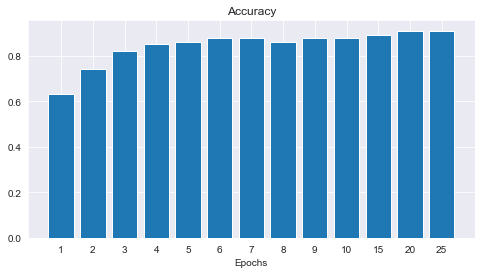

In [6]:
print("RUNNING EPOCH TEST This will take a few moments ...")
ann_list = []
train_results_list = []
epoch_amounts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]

for epoch in epoch_amounts:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, hidden_layer, batch_size=5) # create a new ANN model with a specific batch size
    train_performance = ann.train(X_train, y_train, epoch, lr=0.3) # train the model

    train_results_list.append(train_performance)
    ann_list.append(ann) # maintain each ANN model in a list

print('completed')

#Test Array
test_results_list = []

for model in ann_list: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list.append((mse[0], acc[0]))

    pass
pass

print ("Mean Squared Error and Accuracy Results \n {}".format(test_results_list))

#Build Chart
objects = epoch_amounts
performance = test_results_list

# plot performances bars
fig, axes = plt.subplots(1, 1, figsize=(8,4))
y_pos = np.arange(len(objects))
# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes.bar(y_pos, model_acc, align='center', alpha=1)
axes.set_xticks(y_pos)
axes.set_xticklabels(objects)
axes.set_xlabel('Epochs')
axes.set_title('Accuracy')

RUNNING BATCH TEST This will take a few moments ...
completed
Mean Squared Error and Accuracy Results 
 [(0.006103827450692716, 0.92), (0.0072242576295752274, 0.92), (0.00774338563098286, 0.92), (0.008514000294299573, 0.91), (0.009738446550865174, 0.9), (0.010415666604617112, 0.88), (0.011274915911152717, 0.88), (0.012085709740546947, 0.87), (0.028622519714468293, 0.71), (0.03689389300982045, 0.52), (0.04141754640318579, 0.45), (0.0425849665200541, 0.31)]


Text(0.5, 1.0, 'Accuracy')

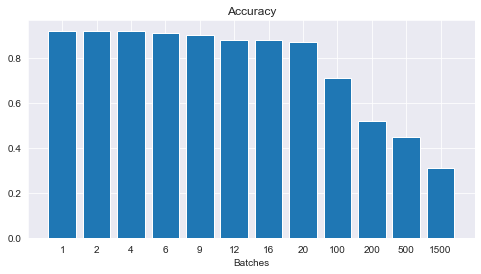

In [7]:
print("RUNNING BATCH TEST This will take a few moments ...")
ann_list = []
train_results_list = []
batch_sizes = [1, 2, 4, 6, 9, 12, 16, 20, 100, 200, 500, len(X_train)]

for batch_size in batch_sizes:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, hidden_layer, batch_size) # create a new ANN model with a specific batch size
    train_performance = ann.train(X_train, y_train, epochs=20, lr=0.3) # train the model

    train_results_list.append(train_performance)
    ann_list.append(ann) # maintain each ANN model in a list

print('completed')

#Test Array
test_results_list = []

for model in ann_list: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list.append((mse[0], acc[0]))

    pass
pass

print ("Mean Squared Error and Accuracy Results \n {}".format(test_results_list))

#Build Chart
objects = batch_sizes
performance = test_results_list

# plot performances bars
fig, axes = plt.subplots(1, 1, figsize=(8,4))
y_pos = np.arange(len(objects))
# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes.bar(y_pos, model_acc, align='center', alpha=1)
axes.set_xticks(y_pos)
axes.set_xticklabels(objects)
axes.set_xlabel('Batches')
axes.set_title('Accuracy')

RUNNING LEARNING RATE TEST This will take a few moments ...
completed
Mean Squared Error and Accuracy Results 
 [(0.02116911414710682, 0.83), (0.01428610393456816, 0.87), (0.012002425928869567, 0.87), (0.011050058375100971, 0.87), (0.01044521562200465, 0.89), (0.010004452360007788, 0.9), (0.009761658633926055, 0.91), (0.009343897077238312, 0.89), (0.00900390197879119, 0.9), (0.009024182297619095, 0.91), (0.012341925177686335, 0.83), (0.04904950658855157, 0.17)]


Text(0.5, 1.0, 'Accuracy')

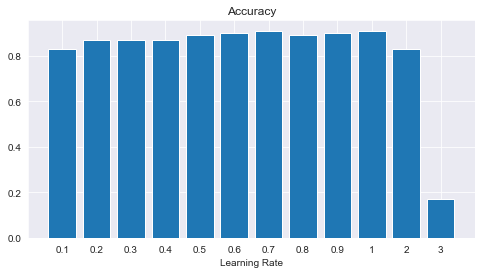

In [9]:
print("RUNNING LEARNING RATE TEST This will take a few moments ...")
ann_list = []
train_results_list = []
learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3]

for rate in learning_rates:
    # configure the layers
    hidden_layer = Layer_Dense(784,200)
    output_layer = Layer_Dense(200,10)

    # create an ANN model
    ann = ANN(output_layer, hidden_layer, batch_size=20) # create a new ANN model with a specific batch size
    train_performance = ann.train(X_train, y_train, epochs=20, lr=rate) # train the model

    train_results_list.append(train_performance)
    ann_list.append(ann) # maintain each ANN model in a list

print('completed')

#Test Array
test_results_list = []

for model in ann_list: 
    df_test_result = model.test(X_test, y_test)
    mse=df_test_result['mean_squared_error'].values
    acc=df_test_result['accuracy'].values

    test_results_list.append((mse[0], acc[0]))

    pass
pass

print ("Mean Squared Error and Accuracy Results \n {}".format(test_results_list))

#Build Chart
objects = learning_rates
performance = test_results_list

# plot performances bars
fig, axes = plt.subplots(1, 1, figsize=(8,4))
y_pos = np.arange(len(objects))
# plot accuracy from performance
model_acc = [x[1] for x in performance]
axes.bar(y_pos, model_acc, align='center', alpha=1)
axes.set_xticks(y_pos)
axes.set_xticklabels(objects)
axes.set_xlabel('Learning Rate')
axes.set_title('Accuracy')